# Noise ceiling function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import scipy.spatial as sp
import scipy.optimize as so
import random

%matplotlib inline

# Import datasets

In [2]:
y_res11 = pd.read_csv('y_res11.csv', header=None)
y_res12 = pd.read_csv('y_res12.csv', header=None)
y_res13 = pd.read_csv('y_res13.csv', header=None)
y_res21 = pd.read_csv('y_res21.csv', header=None)
y_res22 = pd.read_csv('y_res22.csv', header=None)
y_res23 = pd.read_csv('y_res23.csv', header=None)

col_names=['x', 'y', 'z', 'depth']
location11=pd.read_csv('location11.csv',names=col_names)
location12=pd.read_csv('location12.csv',names=col_names)
location13=pd.read_csv('location13.csv',names=col_names)
location21=pd.read_csv('location21.csv',names=col_names)
location22=pd.read_csv('location22.csv',names=col_names)
location23=pd.read_csv('location23.csv',names=col_names)

# View y_res.csv

In [3]:
print(y_res11.shape)
y_res11.head()

(3488, 933)


,0,1,2,3,4,5,6,7,8,9,...,923,924,925,926,927,928,929,930,931,932
0,-26.5160,26.62300,3.0929,-19.6980,-9.94000,13.3980,31.4680,39.0380,-7.9090,30.595,...,-10.58400,-20.8480,-0.41171,-23.511,-5.4647,-34.993,-45.190,7.9113,-6.2091,19.889
1,15.0100,9.73560,20.7270,14.5580,-14.63900,-48.0150,-13.7400,2.3699,19.0750,-14.124,...,22.24100,-10.2100,-0.78411,-37.818,-22.0660,-31.371,-47.510,-5.1689,25.4960,-10.574
2,-1.0803,14.36800,23.3040,-4.7900,-0.81247,-8.3198,29.9200,-9.7703,13.5050,-17.230,...,-26.06400,10.7070,-20.45600,-24.053,-9.7981,-49.775,-40.405,14.2920,-22.0380,37.135
3,-21.6400,-19.04700,-27.3580,13.7920,-13.71200,-13.1390,4.0264,-1.5494,20.5230,11.375,...,12.37900,-8.8534,-21.94300,-23.446,-32.8570,-55.697,-48.037,23.6720,-16.6120,26.502
4,-9.7808,0.83407,-23.7150,-5.2596,-19.04100,-8.0778,12.6460,-37.7300,-8.8727,18.778,...,0.47902,-25.2330,-33.06700,-23.311,-8.5716,-23.852,-70.533,27.3110,-8.6012,16.731


# View location.csv

In [4]:
print(location11.shape)
location11.head()

(933, 4)


,x,y,z,depth
0,-58.710,-64.143,-12.913,1.03130
1,-60.710,-64.135,-12.875,0.94725
2,-58.686,-62.365,-11.998,1.08950
3,-54.706,-66.854,-12.124,1.64540
4,-56.706,-66.845,-12.087,1.12620


# Define a function get correlation from any given y_res

In [5]:
def get_corr(Y_res):
    
    #obtaining the correlation between voxels
    corr=Y_res.corr(method ='pearson')
    corr_tril=np.tril(corr,k=-1)
    Corr=corr_tril[np.nonzero(corr_tril)]
    Corr=Corr.reshape(-1,1)
    Corr=pd.DataFrame(Corr)
    return Corr

# Define a function get design matrix X from dataframe: location
### exp_model: $Corr=\beta_0+\beta_1*exp(-dist*\gamma)+\beta_2*dep1+\beta_3*dep2+\beta4*dep1*dep2$
### power_model: $Corr=\beta_0+\beta_1*eta^{dist}+\beta_2*dep1+\beta_3*dep2+\beta4*dep1*dep2$

In [6]:
def get_design_matrix(Location,gamma=0.2,eta=0.8):

    #Obtaining the distance between voxels
    dist_matrix=sp.distance_matrix(Location.iloc[:,0:2],Location.iloc[:,0:2])
    dist_tril=np.tril(dist_matrix,k=-1)
    rowid,colid=np.nonzero(dist_tril)
    dist=dist_tril[rowid,colid]
    dist=dist.reshape(-1,1)
    
    exp_dist=np.exp(-dist*gamma)
    power_dist=[eta**k for k in dist]

    #Obtaining the depth from the 1st voxel
    dep1=Location.depth[rowid]
    dep1=dep1.values
    dep1=dep1.reshape(-1,1)

    #obtaining depth from the 2ed voxel
    dep2=Location.depth[colid]
    dep2=dep2.values
    dep2=dep2.reshape(-1,1)

    dep1_2=dep1*dep2

    #Creat the design matrix
    X_exp=np.concatenate((exp_dist,dep1,dep2,dep1_2),axis=1)
    names_exp=['exp_dist','dep1','dep2','dep12']
    X_exp=pd.DataFrame(X_exp,columns=names_exp)
    
    X_power=np.concatenate((power_dist,dep1,dep2,dep1_2),axis=1)
    names_power=['power_dist','dep1','dep2','dep12']
    X_power=pd.DataFrame(X_power,columns=names_power)
    
    #make design matrices as a dictionary
    design_dict={"exp": X_exp,
                "power": X_power}
    
    #return a dictionary with model names and corresponding design matrix X
    return design_dict

In [7]:
get_design_matrix(location11)

{'exp':         exp_dist     dep1      dep2     dep12
 0       0.670318  0.94725  1.031300  0.976899
 1       0.700730  1.08950  1.031300  1.123601
 2       0.584059  1.08950  0.947250  1.032029
 3       0.380188  1.64540  1.031300  1.696901
 4       0.267618  1.64540  0.947250  1.558605
 5       0.301237  1.64540  1.089500  1.792663
 6       0.510273  1.12620  1.031300  1.161450
 7       0.380231  1.12620  0.947250  1.066793
 8       0.375458  1.12620  1.089500  1.226995
 9       0.670317  1.12620  1.645400  1.853049
 10      0.583447  0.82555  1.031300  0.851390
 11      0.510212  0.82555  0.947250  0.782002
 12      0.408850  0.82555  1.089500  0.899437
 13      0.449416  0.82555  1.645400  1.358360
 14      0.670452  0.82555  1.126200  0.929734
 15      0.512217  1.11840  1.031300  1.153406
 16      0.583564  1.11840  0.947250  1.059404
 17      0.375428  1.11840  1.089500  1.218497
 18      0.301251  1.11840  1.645400  1.840215
 19      0.449416  1.11840  1.126200  1.259542
 20   

## Function model_evaluation
### taking input: noise matrix, model (design matrix X), evaluation method , num of runs; 
### returning: the $R^2$ for each of the model,  lower bound  and upper bound of noise ceiling

In [8]:
def model_evaluation(Y_res, design_matrix=None, evaluation_method="R_sqr",num_run=8):
    #design_matrix: a dictionary of a list of design matrices (with name as index name)
    
    #add noise ceiling model into the model dictionary
    design_matrix["noise ceiling"]=None

    #split Y_res into n equal pieces according to the number of runs (n)    
    r_sqr_low_result=np.zeros((len(design_matrix),num_run))
    r_sqr_up_result=np.zeros((len(design_matrix),num_run))
    kf = KFold(n_splits=num_run)
    i=0
    for train_index, test_index in kf.split(Y_res):

        #Calculating correlation matrix for train, test and all data
        Corr_train=get_corr(Y_res.loc[train_index])
        Corr_test=get_corr(Y_res.loc[test_index])
        Corr_allrun=get_corr(Y_res)
        
        j=0
        for model_key, model_design_matr in design_matrix.items():
          
            if model_key=="noise ceiling":
                
                ESS_lowbound=np.sum((Corr_train-Corr_test)**2)
                ESS_upbound=np.sum((Corr_allrun-Corr_test)**2)
                mu=np.mean(Corr_test)
                TSS=np.sum((Corr_test-mu)**2)
                
                #Calculating R^2 for the model
                if evaluation_method=="R_sqr":
                    r_sqr_low=1-ESS_lowbound/TSS
                    r_sqr_up=1-ESS_upbound/TSS                
            else:              
                #
                linmodel_train = LinearRegression().fit(model_design_matr, Corr_train)
                linmodel_all = LinearRegression().fit(model_design_matr, Corr_allrun)
                
                #calculating R^2 for the model
                if evaluation_method=="R_sqr":
                    r_sqr_low=linmodel_train.score(model_design_matr, Corr_test) 
                    r_sqr_up=linmodel_all.score(model_design_matr, Corr_test)
                        
            #Store lower and upper bound of R^2 for each model into a numpy array
            r_sqr_low_result[j,i]=r_sqr_low
            r_sqr_up_result[j,i]=r_sqr_up
            
            j+=1
            
        i+=1
            
    #taking average among 8 fits (taking average along the row)     
    R_sqr_lowbound=np.mean(r_sqr_low_result, axis = 1)
    R_sqr_upbound=np.mean(r_sqr_up_result, axis=1)
    
    #build up a dictionary to store the result:
    result={}
    k=0
    for model_key in design_matrix:      
        result[model_key]=[R_sqr_lowbound[k],R_sqr_upbound[k]]
        k+=1
    
    #Reture the result: a dictionary that contains the lower bound and upper bound for each model
    return result

In [10]:
model_dict=get_design_matrix(location11)


In [11]:
results_model_evaluat=model_evaluation(y_res11, model_dict)

In [12]:
result1=results_model_evaluat.copy()
result1

{'exp': [0.061917125189819094, 0.06267792479555069],
 'power': [0.06203040443232423, 0.06278922092817175],
 'noise ceiling': [0.16107911783373707, 0.3605663390102093]}

### Test function

## Creating a graph showing the result from function: model_evaluation()

In [15]:
def barplot_noisebounds(result_model_evaluation, plot_type="bar"):
    
    result_model_eval_copy=result_model_evaluation.copy()
    #obtain the lower and upper bounds for noise ceiling
    noise_lowbound, noise_upbound=result_model_eval_copy.pop("noise ceiling")
    
    model_name=[key for key in result_model_eval_copy]
    r_sqr=[lower_bound[0] for lower_bound in result_model_eval_copy.values()]
    
    if plot_type=="bar":
        plt.figure(figsize=(7.5,5))
        ax=sns.barplot(model_name,r_sqr)
        #change the bar width 
        widthbars=[0.3,0.3]
        for bar ,newwidth in zip(ax.patches, widthbars):
            x=bar.get_x()
            width=bar.get_width()
            center=x+width/2
            bar.set_x(center-newwidth/2.)
            bar.set_width(newwidth)
        #ax.set(ylim=(0, 0.2))
        ax.axhline(noise_lowbound, ls='--',color="gray")
        ax.axhline(noise_upbound, ls='--',color="gray")

### Result from subject 1 region1

In [13]:
model_dict=get_design_matrix(location11)
results_model_evaluat=model_evaluation(y_res11, model_dict)
results_model_evaluat

{'exp': [0.061917125189819094, 0.06267792479555069],
 'power': [0.06203040443232423, 0.06278922092817175],
 'noise ceiling': [0.16107911783373707, 0.3605663390102093]}

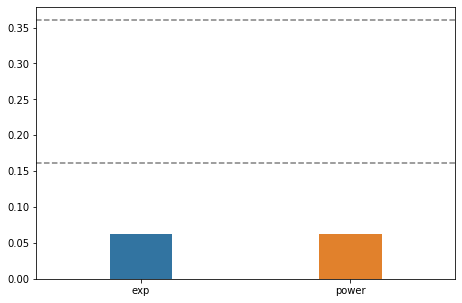

In [16]:
barplot_noisebounds(results_model_evaluat)

### Result from subject 1 region 2

In [17]:
model_dict12=get_design_matrix(location12)
results_model_evaluat12=model_evaluation(y_res12, model_dict12)
results_model_evaluat12

{'exp': [0.10959755774601727, 0.111865895073857],
 'power': [0.10976842184718591, 0.11203733261173494],
 'noise ceiling': [0.31225772168404214, 0.4749372760342793]}

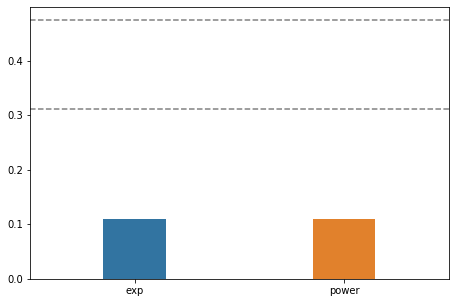

In [18]:
barplot_noisebounds(results_model_evaluat12)

### Result from subject 1 region 3

In [19]:
model_dict13=get_design_matrix(location13)
results_model_evaluat13=model_evaluation(y_res13, model_dict13)
results_model_evaluat13

{'exp': [0.030324517984222976, 0.032658774384733205],
 'power': [0.03047033682626825, 0.03280173726159839],
 'noise ceiling': [0.10935000350996608, 0.32311350204718653]}

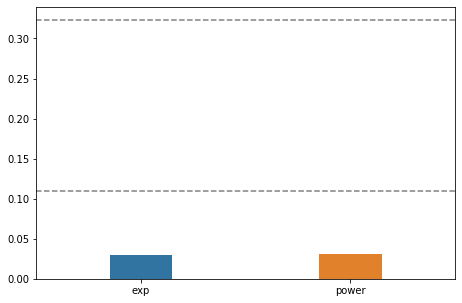

In [20]:
barplot_noisebounds(results_model_evaluat13)

### Result from subject 2 region 1

In [21]:
model_dict21=get_design_matrix(location21)
results_model_evaluat21=model_evaluation(y_res21, model_dict21)
results_model_evaluat21

{'exp': [0.04102099501199952, 0.04186645591164358],
 'power': [0.04105436735906269, 0.04189959915336465],
 'noise ceiling': [0.5790216753420147, 0.677471308361812]}

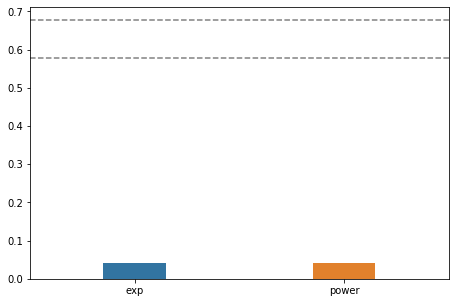

In [22]:
barplot_noisebounds(results_model_evaluat21)

### Result from subject 2 region 2

In [23]:
model_dict22=get_design_matrix(location22)
results_model_evaluat22=model_evaluation(y_res22, model_dict22)
results_model_evaluat22

{'exp': [0.12229098517988554, 0.12462058712479583],
 'power': [0.12256960706017499, 0.12490038442714382],
 'noise ceiling': [0.5291806168497728, 0.6395822277745999]}

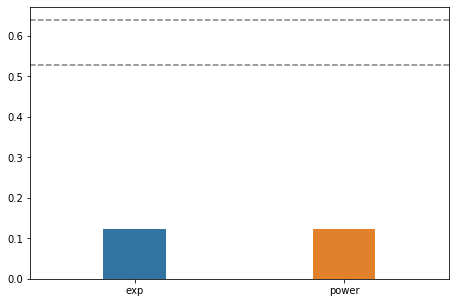

In [24]:
barplot_noisebounds(results_model_evaluat22)

### Result from subject 2 region 3

In [25]:
model_dict23=get_design_matrix(location23)
results_model_evaluat23=model_evaluation(y_res23, model_dict23)
results_model_evaluat23

{'exp': [0.03642208600715162, 0.03687845694416203],
 'power': [0.03663244913292328, 0.03708969775421496],
 'noise ceiling': [0.35659577311250357, 0.5067820134729759]}

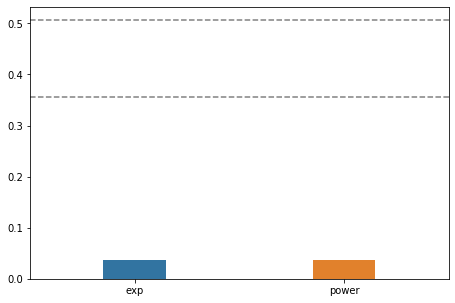

In [26]:
barplot_noisebounds(results_model_evaluat23)